In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

/tmp/ipykernel_505105/1226147920.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# # !source activate jupyter_launcher
# !pip3 install numba
# !pip3 install matplotlib
# !pip3 install scipy
# !pip3 install torch
# !pip3 install torchvision
# !pip3 install sklearn
# !pip3 install pycuda
# !pip3 install tqdm
# !pip3 install seaborn
# !pip3 install h5py
# !pip3 install hdfdict
# !pip3 install ipywidgets
# !pip3 install numpy==1.20

In [3]:
import sys
import os
import copy
import pathlib
from pathlib import Path
import time
import gc

In [4]:
from tqdm import tqdm, trange

import numpy as np
import scipy

import torch
import torchvision
import torchvision.transforms as transforms

In [5]:
### Parse arguments

# import sys
# path_script, path_params, dir_save = sys.argv
                
# import json
# with open(path_params, 'r') as f:
#     params = json.load(f)

# import shutil
# shutil.copy2(path_script, str(Path(dir_save) / Path(path_script).name));


# dir_save = '/media/rich/bigSSD/analysis_data/ROI_net_training/testing_dispatcher_20220504'
dir_save = Path(r'/media/rich/bigSSD/')

# params_template = {
params = {
    'pref_log_all_steps': False,
    'paths': {
        'dir_github':'/media/rich/Home_Linux_partition/github_repos',
        'fileName_save_model':'ConvNext_tiny_1.0unfrozen_simCLR',
        'path_data_training':'/media/rich/bigSSD/analysis_data/ROIs_for_training/sf_sparse_36x36_20220503.npz',
    },
    
    'prefs': {
        'saveModelIteratively':True,
        'saveLogs':True,
    },
    
    'useGPU_training': True,
    'useGPU_dataloader': False,
    'dataloader_kwargs':{
        'batch_size': 1024,
        'shuffle': True,
        'drop_last': True,
        'pin_memory': True,
        'num_workers': 18,
        'persistent_workers': True,
        'prefetch_factor': 2,
#         'num_workers': 4,
#         'persistent_workers': True,
#         'prefetch_factor': 1,
    },
    'inner_batch_size': 256,

    'torchvision_model': 'convnext_tiny',

    'pre_head_fc_sizes': [256, 128],
    'post_head_fc_sizes': [128],
    'block_to_unfreeze': '6.0',
    'n_block_toInclude': 9,
    'head_nonlinearity': 'GELU',
    
    'lr': 1*10**-2,
    'penalty_orthogonality':0.05,
    'weight_decay': 0.0000,
    'gamma': 1-0.0000,
    'n_epochs': 9999999,
    'temperature': 0.1,
    'l2_alpha': 0.0000,
    
    'augmentation': {
        'Scale_image_sum': {'sum_val':1, 'epsilon':1e-9, 'min_sub':True},
        'AddPoissonNoise': {'scaler_bounds':(10**(3.5), 10**(4)), 'prob':0.7, 'base':1000, 'scaling':'log'},
        'Horizontal_stripe_scale': {'alpha_min_max':(0.5, 1), 'im_size':(36,36), 'prob':0.3},
        'Horizontal_stripe_shift': {'alpha_min_max':(1  , 2), 'im_size':(36,36), 'prob':0.3},
        'RandomHorizontalFlip': {'p':0.5},
        'RandomAffine': {
            'degrees':(-180,180),
            'translate':(0.1, 0.1), #0, .3, .45 (DEFAULT)
            'scale':(0.6, 1.2), # no scale (1,1), (0.4, 1.5)
            'shear':(-8, 8, -8, 8),
#             'interpolation':torchvision.transforms.InterpolationMode.BILINEAR, 
            'interpolation':'bilinear', 
            'fill':0, 
            'fillcolor':None, 
            'resample':None,
        },
        'AddGaussianNoise': {'mean':0, 'std':0.0010, 'prob':0.5},
        'ScaleDynamicRange': {'scaler_bounds':(0,1), 'epsilon':1e-9},
        'WarpPoints': {
            'r':[0.3, 0.6],
            'cx':[-0.3, 0.3],
            'cy':[-0.3, 0.3], 
            'dx':[-0.24, 0.24], 
            'dy':[-0.24, 0.24], 
            'n_warps':2,
            'prob':0.5,
            'img_size_in':[36, 36],
#             'img_size_out':[72,72],
            'img_size_out':[224,224],
        },
        'TileChannels': {'dim':0, 'n_channels':3},
    },
}

In [6]:
### Import personal libraries

import sys

sys.path.append(params['paths']['dir_github'])

%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import torch_helpers, math_functions, classification, h5_handling, plotting_helpers, indexing, misc, decomposition, path_helpers
from GCaMP_ROI_classifier import util, models, training, augmentation, dataset

In [7]:
def write_to_log(path_log, text, mode='a', start_on_new_line=True):
    with open(path_log, mode=mode) as log:
        if start_on_new_line==True:
            log.write('\n')
        log.write(text)

In [ ]:
write_to_log(path_log=path_saveLog, text=f'sys.version: {sys.version_info}')
write_to_log(path_log=path_saveLog, text=f"sys.version: {os.environ['CONDA_DEFAULT_ENV']}")

In [8]:
### Prepare paths

path_saveModel = str((dir_save / params['paths']['fileName_save_model']).with_suffix('.pth'))
path_saveLog = str(dir_save / 'log.txt')
path_saveLoss = (dir_save / 'loss.npy')

device_train = torch_helpers.set_device(use_GPU=params['useGPU_training'], verbose=False)

In [9]:
### Import unlabeled training data

import scipy.sparse

sf_sparse = scipy.sparse.load_npz(params['paths']['path_data_training'])

sf_dense = torch.as_tensor(sf_sparse.toarray().reshape(sf_sparse.shape[0], 36,36), dtype=torch.float32)

##toss any NaNs

# print(f'Number of masks: {sf_dense.shape}')
ROIs_without_NaNs = ~torch.any(torch.any(torch.isnan(sf_dense), dim=1), dim=1)
ROIs_nonAllZero = (torch.max(torch.max(sf_dense, dim=1)[0], dim=1)[0] > 0)
ROIs_toKeep = torch.where(ROIs_without_NaNs * ROIs_nonAllZero)[0]
masks_cat = sf_dense[ROIs_toKeep]

n_masks_removed = np.sum(sf_dense.shape[0] - ROIs_toKeep.shape[0])
# print(f'Number of masks: {masks_cat.shape}')

In [10]:
### Define augmentation pipeline

transforms = torch.nn.Sequential(
    *[augmentation.__dict__[key](**params) for key,params in params['augmentation'].items()]
)
scripted_transforms = torch.jit.script(transforms)

device_dataloader = torch_helpers.set_device(use_GPU=params['useGPU_dataloader'])

dataset_train = dataset.dataset_simCLR(
    torch.as_tensor(masks_cat, device=device_dataloader, dtype=torch.float32), 
    torch.as_tensor(torch.zeros(masks_cat.shape[0]), device=device_dataloader, dtype=torch.float32),
    n_transforms=2,
    class_weights=np.array([1]),
    # class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
    transform=scripted_transforms,
    # DEVICE='cpu',
    DEVICE=device_dataloader,
    dtype_X=torch.float32,
    dtype_y=torch.int64,
    # temp_uncertainty=1
)

dataloader_train = torch.utils.data.DataLoader(
    dataset_train,
    **params['dataloader_kwargs']

#     batch_size=1024,
#     shuffle=True,
#     drop_last=True,
#     pin_memory=True,
#     num_workers=36,
#     persistent_workers=True,
#     prefetch_factor=3,
    
#     batch_size=1024,
#     shuffle=False,
#     drop_last=True,
#     pin_memory=False,
#     num_workers=36,
#     persistent_workers=True,
#     prefetch_factor=3,
)

device: 'cpu'


In [11]:
# import matplotlib.pyplot as plt
# %matplotlib notebook

# idx_rand = np.random.randint(0,masks_cat.shape[0], 10)
# for ii in idx_rand:
#     fig, axs = plt.subplots(1,2)
#     # print(dataset_train[ii][0][0][0].shape)
#     axs[0].imshow(dataset_train[ii][0][0][0].cpu())
#     axs[1].imshow(dataset_train[ii][0][1][0].cpu())

In [12]:
### Define ModelTackOn

class ModelTackOn(torch.nn.Module):
    def __init__(
        self, 
        base_model, 
        un_modified_model,
        data_dim=(1,3,36,36), 
        pre_head_fc_sizes=[100], 
        post_head_fc_sizes=[100], 
        classifier_fc_sizes=None, 
        nonlinearity='relu', 
        kwargs_nonlinearity={},
    ):
            super(ModelTackOn, self).__init__()
            self.base_model = base_model
            final_base_layer = list(un_modified_model.children())[-1]
            # final_base_layer = list(list(model.children())[-1].children())[-1]
            # print(final_base_layer)
            
            self.data_dim = data_dim

            self.pre_head_fc_lst = []
            self.post_head_fc_lst = []
            self.classifier_fc_lst = []
                
            self.nonlinearity = nonlinearity
            self.kwargs_nonlinearity = kwargs_nonlinearity

            self.init_prehead(final_base_layer, pre_head_fc_sizes)
            self.init_posthead(pre_head_fc_sizes[-1], post_head_fc_sizes)
            if classifier_fc_sizes is not None:
                self.init_classifier(pre_head_fc_sizes[-1], classifier_fc_sizes)
            
    def init_prehead(self, prv_layer, pre_head_fc_sizes):
        for i, pre_head_fc in enumerate(pre_head_fc_sizes):
            if i == 0:
#                 in_features = prv_layer.in_features if hasattr(prv_layer,'in_features') else 1280
#                 in_features = prv_layer.in_features if hasattr(prv_layer,'in_features') else 960
#                 in_features = prv_layer.in_features if hasattr(prv_layer,'in_features') else 768
#                 in_features = prv_layer.in_features if hasattr(prv_layer,'in_features') else 1536
#                 in_features = prv_layer.in_features if hasattr(prv_layer,'in_features') else 1024
                in_features = self.base_model(torch.rand(*(self.data_dim))).data.squeeze().shape[0]  ## RH EDIT
            else:
                in_features = pre_head_fc_sizes[i - 1]
            fc_layer = torch.nn.Linear(in_features=in_features, out_features=pre_head_fc)
            self.add_module(f'PreHead_{i}', fc_layer)
            self.pre_head_fc_lst.append(fc_layer)

#             if i < len(pre_head_fc_sizes) - 1:
#             non_linearity = torch.nn.ReLU()
#             non_linearity = torch.nn.GELU()
            non_linearity = torch.nn.__dict__[self.nonlinearity](**self.kwargs_nonlinearity)
            self.add_module(f'PreHead_{i}_NonLinearity', non_linearity)
            self.pre_head_fc_lst.append(non_linearity)

    def init_posthead(self, prv_size, post_head_fc_sizes):
        for i, post_head_fc in enumerate(post_head_fc_sizes):
            if i == 0:
                in_features = prv_size
            else:
                in_features = post_head_fc_sizes[i - 1]
            fc_layer = torch.nn.Linear(in_features=in_features, out_features=post_head_fc)
            self.add_module(f'PostHead_{i}', fc_layer)
            self.post_head_fc_lst.append(fc_layer)

#                 non_linearity = torch.nn.ReLU()
#                 non_linearity = torch.nn.GELU()
            non_linearity = torch.nn.__dict__[self.nonlinearity](**self.kwargs_nonlinearity)    
            self.add_module(f'PostHead_{i}_NonLinearity', non_linearity)
            self.pre_head_fc_lst.append(non_linearity)
    
    def init_classifier(self, prv_size, classifier_fc_sizes):
            for i, classifier_fc in enumerate(classifier_fc_sizes):
                if i == 0:
                    in_features = prv_size
                else:
                    in_features = classifier_fc_sizes[i - 1]
            fc_layer = torch.nn.Linear(in_features=in_features, out_features=classifier_fc)
            self.add_module(f'Classifier_{i}', fc_layer)
            self.classifier_fc_lst.append(fc_layer)

    def reinit_classifier(self):
        for i_layer, layer in enumerate(self.classifier_fc_lst):
            layer.reset_parameters()
    
#     def forward(self, X):
#         interim = self.base_model(X)
#         interim = self.get_head(interim)
#         interim = self.get_latent(interim)
#         return interim

    def forward_classifier(self, X):
        interim = self.base_model(X)
        interim = self.get_head(interim)
        interim = self.classify(interim)
        return interim

    def forward_latent(self, X):
        interim = self.base_model(X)
        interim = self.get_head(interim)
        interim = self.get_latent(interim)
        return interim


    def get_head(self, base_out):
        # print('base_out', base_out.shape)
        head = base_out
        for pre_head_layer in self.pre_head_fc_lst:
          # print('pre_head_layer', pre_head_layer.in_features)
          head = pre_head_layer(head)
          # print('head', head.shape)
        return head

    def get_latent(self, head):
        latent = head
        for post_head_layer in self.post_head_fc_lst:
            latent = post_head_layer(latent)
        return latent

    def classify(self, head):
        logit = head
        for classifier_layer in self.classifier_fc_lst:
            logit = classifier_layer(logit)
        return logit

    def set_pre_head_grad(self, requires_grad=True):
        for layer in self.pre_head_fc_lst:
            for param in layer.parameters():
                param.requires_grad = requires_grad
                
    def set_post_head_grad(self, requires_grad=True):
        for layer in self.post_head_fc_lst:
            for param in layer.parameters():
                param.requires_grad = requires_grad

    def set_classifier_grad(self, requires_grad=True):
        for layer in self.classifier_fc_lst:
            for param in layer.parameters():
                param.requires_grad = requires_grad

    def prep_contrast(self):
        self.set_pre_head_grad(requires_grad=True)
        self.set_post_head_grad(requires_grad=True)
        self.set_classifier_grad(requires_grad=False)

    def prep_classifier(self):
        self.set_pre_head_grad(requires_grad=False)
        self.set_post_head_grad(requires_grad=False)
        self.set_classifier_grad(requires_grad=True)

In [13]:
### Import pretrained model

import torchvision.models

# base_model_frozen = torchvision.models.resnet101(pretrained=True)
# base_model_frozen = torchvision.models.resnet18(pretrained=True)
# base_model_frozen = torchvision.models.wide_resnet50_2(pretrained=True)
# base_model_frozen = torchvision.models.resnet50(pretrained=True)

# base_model_frozen = torchvision.models.efficientnet_b0(pretrained=True)

# base_model_frozen = torchvision.models.convnext_tiny(pretrained=True)
# base_model_frozen = torchvision.models.convnext_small(pretrained=True)
# base_model_frozen = torchvision.models.convnext_base(pretrained=True)
# base_model_frozen = torchvision.models.convnext_large(pretrained=True)


# base_model_frozen = torchvision.models.mobilenet_v3_large(pretrained=True)

base_model_frozen = torchvision.models.__dict__[params['torchvision_model']](pretrained=True)

for param in base_model_frozen.parameters():
    param.requires_grad = False

In [212]:
# base_model_frozen2 = torchvision.models.__dict__[params['torchvision_model']](pretrained=True)
# model_chopped2 = torch.nn.Sequential(list(base_model_frozen2.children())[0][:params['n_block_toInclude']])  ## 0.
# model_chopped_pooled2 = torch.nn.Sequential(model_chopped2, torch.nn.AdaptiveAvgPool2d(output_size=1), torch.nn.Flatten())  ## 1.

In [14]:
### Make combined model

## Tacking on the latent layers needs to be done in a few steps.

## 0. Chop the base model
## 1. Tack on a pooling layer to reduce the size of the convlutional parameters
## 2. Determine the size of the output (internally done in ModelTackOn)
## 3. Tack on a linear layer of the correct size  (internally done in ModelTackOn)


model_chopped = torch.nn.Sequential(list(base_model_frozen.children())[0][:params['n_block_toInclude']])  ## 0.
model_chopped_pooled = torch.nn.Sequential(model_chopped, torch.nn.AdaptiveAvgPool2d(output_size=1), torch.nn.Flatten())  ## 1.

image_out_size = list(dataset_train[0][0][0].shape)
data_dim = tuple([1] + list(image_out_size))

## 2. , 3.
model = ModelTackOn(
#     model_chopped.to('cpu'),
    model_chopped_pooled.to('cpu'),
    base_model_frozen.to('cpu'),
    data_dim=data_dim,
    pre_head_fc_sizes=params['pre_head_fc_sizes'], 
    post_head_fc_sizes=params['post_head_fc_sizes'], 
    classifier_fc_sizes=None,
    nonlinearity=params['head_nonlinearity'],
    kwargs_nonlinearity={},
)
model.train();

In [15]:
### unfreeze particular blocks in model

mnp = [name for name, param in model.named_parameters()]  ## 'model named parameters'
mnp_blockNums = [name[name.find('.'):name.find('.')+8] for name in mnp]  ## pulls out the numbers just after the model name
mnp_nums = [path_helpers.get_nums_from_string(name) for name in mnp_blockNums]  ## converts them to numbers
block_to_freeze_nums = path_helpers.get_nums_from_string(params['block_to_unfreeze'])  ## converts the input parameter specifying the block to freeze into a number for comparison

m_baseName = mnp[0][:mnp[0].find('.')]

for ii, (name, param) in enumerate(model.named_parameters()):
    if m_baseName in name:
#         print(name)
        if mnp_nums[ii] < block_to_freeze_nums:
            param.requires_grad = False
        elif mnp_nums[ii] >= block_to_freeze_nums:
            param.requires_grad = True

names_layers_requiresGrad = [( param.requires_grad , name ) for name,param in list(model.named_parameters())]

In [210]:
names_layers_requiresGrad

[(False, 'features.0.0.weight'),
 (False, 'features.0.0.bias'),
 (False, 'features.0.1.weight'),
 (False, 'features.0.1.bias'),
 (False, 'features.1.0.layer_scale'),
 (False, 'features.1.0.block.0.weight'),
 (False, 'features.1.0.block.0.bias'),
 (False, 'features.1.0.block.2.weight'),
 (False, 'features.1.0.block.2.bias'),
 (False, 'features.1.0.block.3.weight'),
 (False, 'features.1.0.block.3.bias'),
 (False, 'features.1.0.block.5.weight'),
 (False, 'features.1.0.block.5.bias'),
 (False, 'features.1.1.layer_scale'),
 (False, 'features.1.1.block.0.weight'),
 (False, 'features.1.1.block.0.bias'),
 (False, 'features.1.1.block.2.weight'),
 (False, 'features.1.1.block.2.bias'),
 (False, 'features.1.1.block.3.weight'),
 (False, 'features.1.1.block.3.bias'),
 (False, 'features.1.1.block.5.weight'),
 (False, 'features.1.1.block.5.bias'),
 (False, 'features.1.2.layer_scale'),
 (False, 'features.1.2.block.0.weight'),
 (False, 'features.1.2.block.0.bias'),
 (False, 'features.1.2.block.2.weight'

In [17]:
### Save run outputs

## The training step is written so that it can run until a job ends, so this needs to be saved before

run_outputs = {
    'dir_save': str(dir_save),    
    'path_save_runOutputs': str(dir_save / 'run_outputs.json'),    
    'path_saveModel': str(path_saveModel),
    'path_saveLog': str(path_saveLog),
    'path_saveLoss': str(path_saveLoss),
    'device_train': device_train,
    'masks_training_shape': list(masks_cat.shape),
    'n_masks_removed': int(n_masks_removed),
    'image_resized_shape': list(dataset_train[0][0][0].shape),
    'names_layers_requiresGrad': names_layers_requiresGrad,
}
run_outputs;

import json
with open(run_outputs['path_save_runOutputs'], 'w') as f:
    json.dump(run_outputs, f) 

In [18]:
### Training

model.to(device_train)
model.prep_contrast()
model.forward = model.forward_latent

from torch.nn import CrossEntropyLoss
from torch.optim import Adam

criterion = [CrossEntropyLoss()]
optimizer = Adam(
    model.parameters(), 
    lr=params['lr'],
#     lr=1*10**-2,
)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,
                                                   gamma=params['gamma'],
#                                                    gamma=1,
                                                  )

criterion = [_.to(device_train) for _ in criterion]

In [20]:
# model.load_state_dict(torch.load('/media/rich/bigSSD/ConvNext_tiny_1.pth'))

In [ ]:
losses_train, losses_val = [], [np.nan]
for epoch in tqdm(range(params['n_epochs'])):
    print(f'epoch: {epoch}')
    
    losses_train = training.epoch_step(
        dataloader_train, 
        model, 
        optimizer, 
        criterion,
        scheduler=scheduler,
        temperature=params['temperature'],
        # l2_alpha,
        penalty_orthogonality=params['penalty_orthogonality'],
        mode='semi-supervised',
        loss_rolling_train=losses_train, 
        loss_rolling_val=losses_val,
        device=device_train, 
        inner_batch_size=params['inner_batch_size'],
        verbose=2,
        verbose_update_period=1,

#                                     do_validation=False,
#                                     X_val=x_feed_through_val,
#                                     y_val=torch.as_tensor(y_val, device=DEVICE)
)
    
    ## save loss stuff
    if params['prefs']['saveLogs']:
        write_to_log(path_log=path_saveLog, text=f'time:{time.ctime()}, completed epoch: {epoch}, loss: {losses_train[-1]}, lr: {scheduler.get_last_lr()[0]}')
        np.save(path_saveLoss, losses_train)
    
    ## if loss becomes NaNs, don't save the network and stop training
    if torch.isnan(torch.as_tensor(losses_train[-1])):
        write_to_log(path_log=path_saveLog, text=f'time:{time.ctime()}, EXITED DUE TO loss==NaN')
        break
        
    ## save model
    if params['prefs']['saveModelIteratively']:
        torch.save(model.state_dict(), path_saveModel)

<IPython.core.display.Javascript object>


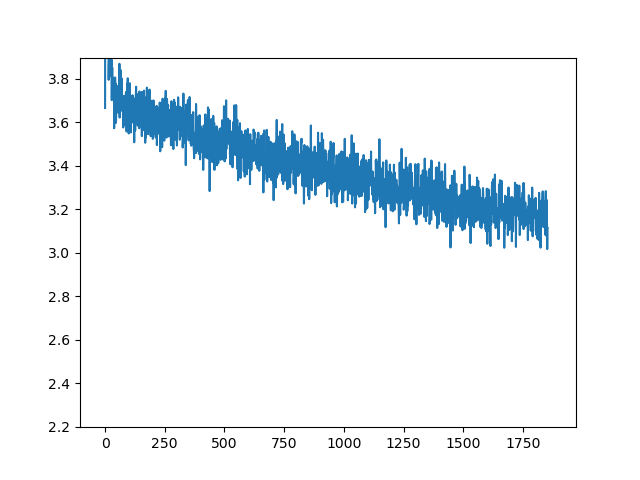

In [22]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.figure()
plt.plot(losses_train)
# plt.yscale('log')
plt.ylim([0, None]);

In [ ]:
# model.load_state_dict(torch.load('/media/rich/bigSSD/EfficientNet_b0_7unfrozen_simCLR.pth'))
# model.eval()

## Use sklearn to train classifier

In [23]:
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

<IPython.core.display.Javascript object>


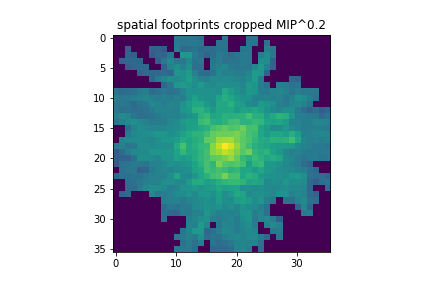

In [284]:
path_stat = r'/media/rich/bigSSD/for_Josh/SimCLR-Label-Data/mouse2_6__20210409/stat.npy'
path_labels = [r'/media/rich/bigSSD/for_Josh/SimCLR-Label-Data/mouse2_6__20210409/labels_round2_sesh1.npy', '/media/rich/bigSSD/for_Josh/SimCLR-Label-Data/mouse2_6__20210409/labels_round2_sesh1.npy']

# path_stat = r'/media/rich/bigSSD/for_Josh/SimCLR-Label-Data/mouse6_28 _ day20200815/stat.npy'
# path_labels = r'/media/rich/bigSSD/for_Josh/SimCLR-Label-Data/mouse6_28 _ day20200815/labels_posthoc_all.npy'


images_labeled = np.concatenate(
    util.import_multiple_stat_files(   
        paths_statFiles=[path_stat],
        out_height_width=[36,36],
        max_footprint_width=241,
        plot_pref=True
    )
)

# labels = classification.squeeze_integers(np.concatenate([np.load(path_labels)]))

labels = classification.squeeze_integers(np.concatenate([np.load(path) for path in path_labels]))
images_labeled = np.concatenate((images_labeled, images_labeled), axis=0)

assert images_labeled.shape[0] == labels.shape[0] , 'num images in stat files does not correspond to num labels'

In [285]:
np.unique(labels)

array([0., 1., 2., 3., 4.])

In [286]:
idx_toKeep = np.where(np.logical_not(labels == 4))[0]

images_labeled_clean = images_labeled[idx_toKeep]
labels_clean = labels[idx_toKeep]

In [287]:
transforms_classifier = torch.nn.Sequential(
    augmentation.ScaleDynamicRange(scaler_bounds=(0,1)),
    
    torchvision.transforms.Resize(
        size=(224, 224),
#         size=(180, 180),
#         size=(72, 72),        
        interpolation=torchvision.transforms.InterpolationMode.BILINEAR), 
    
    augmentation.TileChannels(dim=0, n_channels=3),
)

scripted_transforms_classifier = torch.jit.script(transforms_classifier)


In [288]:
def helper_make_dataset(X):
    out = dataset.dataset_simCLR(
        X=torch.as_tensor(X, device='cpu', dtype=torch.float32),
        y=torch.as_tensor(torch.zeros(X.shape[0]), device='cpu', dtype=torch.float32),
        n_transforms=1,
        class_weights=np.array([1]),
        transform=scripted_transforms_classifier,
        DEVICE='cpu',
        dtype_X=torch.float32,
    )
    return out

def helper_make_dataloader(ds):
    out = torch.utils.data.DataLoader( 
        ds,
        batch_size=128,
        shuffle=False,
        drop_last=False,
#         pin_memory=True,
#         num_workers=36,
#         persistent_workers=True,
#         prefetch_factor=2
    )
    return out

In [289]:
dataset_labeled_clean = helper_make_dataset(images_labeled_clean)
    
dataloader_labeled_clean = helper_make_dataloader(dataset_labeled_clean)

In [290]:
DEVICE = torch_helpers.set_device(use_GPU=True)

device: 'cuda:0'


In [329]:
model.eval()
model.to(DEVICE)
features_nn = torch.cat([model.base_model(data[0][0].to(DEVICE)).detach().cpu() for data in dataloader_labeled_clean], dim=0)

run a sweep of logistic regressions over C (1/L2) parameter

In [330]:
def get_balanced_sample_weights(labels):
    labels = np.int64(labels.copy())
    counts, vals = np.histogram(labels, bins=np.concatenate((np.unique(labels), [labels.max()+1])))
    vals = vals[:-1]

    n_labels = len(labels)
    weights = n_labels / counts
    
    sample_weights = np.array([weights[l] for l in labels])
    
    return sample_weights

In [331]:
from kymatio import Scattering2D

def get_latents_swt(sfs, swt, device_model):
    sfs = torch.as_tensor(np.ascontiguousarray(sfs[None,...]), device=device_model, dtype=torch.float32)
    latents_swt = swt(sfs[None,...]).squeeze()
    latents_swt = latents_swt.reshape(latents_swt.shape[0], -1)
    return latents_swt


device_model = torch_helpers.set_device(use_GPU=True)

scattering = Scattering2D(J=2, L=8, shape=images_labeled_clean[0].shape[-2:])
if device_model != 'cpu':
    scattering = scattering.cuda()

latents_swt = get_latents_swt(images_labeled_clean, scattering.cuda(), device_model).cpu()

device: 'cuda:0'


/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-21.12/lib/python3.8/site-packages/kymatio/frontend/entry.py:20: DeprecationWarning: Torch frontend is currently the default, but NumPy will become the default in the next version.
  warnings.warn("Torch frontend is currently the default, but NumPy will become the default in the next"


In [332]:
import scipy.stats

In [333]:
torch.corrcoef(features_nn.T).shape

torch.Size([768, 768])

<IPython.core.display.Javascript object>


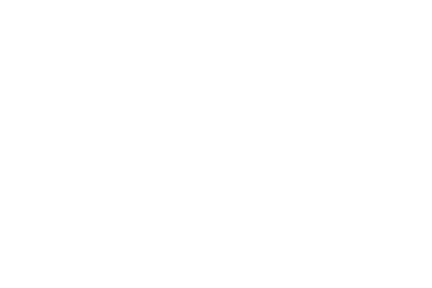

In [334]:
%matplotlib notebook
plt.figure()
plt.imshow(features_nn, aspect='auto',)

<IPython.core.display.Javascript object>


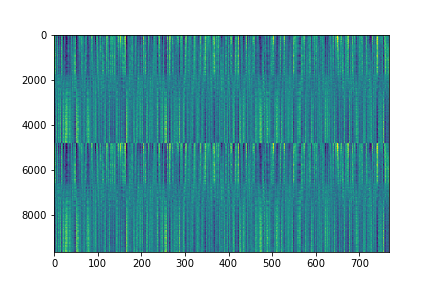

In [335]:
%matplotlib notebook
plt.figure()
plt.imshow(scipy.stats.zscore(features_nn, axis=0), aspect='auto', vmin=-0.8, vmax=1,)

In [336]:
features_nn_z = scipy.stats.zscore(features_nn.numpy(), axis=0)
features_nn_z = features_nn_z[:, ~np.isnan(features_nn_z[0,:])]
features_nn_z = torch.as_tensor(features_nn_z, dtype=torch.float32)

In [337]:
features_nn_z.shape

torch.Size([9630, 768])

In [338]:
comp_nn, scores_nn, SVs, EVR_nn = decomposition.torch_pca(features_nn_z, rank=40, zscore=True)
# comp_nn, scores_nn, SVs, EVR_nn = decomposition.torch_pca(features_nn, rank=60, zscore=True)
comp, scores_swt, SVs, EVR_swt = decomposition.torch_pca(latents_swt, rank=20)
comp, scores_image, SVs, EVR_image = decomposition.torch_pca(images_labeled_clean.reshape(images_labeled_clean.shape[0], -1), rank=5)

<IPython.core.display.Javascript object>


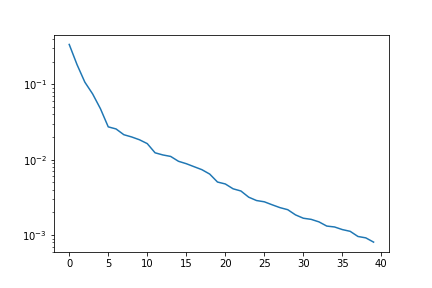

In [339]:
plt.figure()
plt.plot(EVR_nn)
plt.yscale('log')

In [340]:
features_nn.shape

torch.Size([9630, 768])

<IPython.core.display.Javascript object>


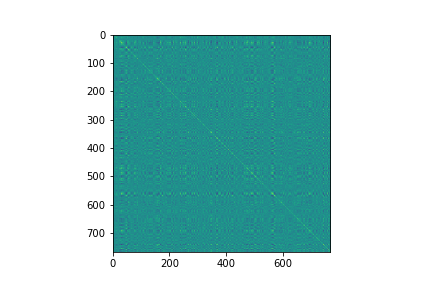

In [341]:
plt.figure()
plt.imshow(torch.corrcoef(features_nn.T))

In [342]:
# comp, features_norm, SVs, EVR = decomposition.torch_pca(features_norm, rank=60)

In [343]:
# comp, features_norm, SVs, EVR = decomposition.torch_pca(features_all, rank=60)

In [344]:
# features_norm = torch.cat([val / torch.std(val) for val in [scores_nn, scores_swt]], dim=1)

In [345]:
# features_norm = torch.cat([val / torch.std(val, dim=0).mean() for val in [scores_nn]], dim=1)
# features_norm = torch.cat([val / torch.std(val, dim=0).mean() for val in [scores_swt]], dim=1)
# features_norm = torch.cat([val / torch.std(val, dim=0).mean() for val in [scores_image]], dim=1)
features_norm = torch.cat([val / torch.std(val, dim=0).mean() for val in [scores_nn, scores_swt]], dim=1)
# features_norm = torch.cat([val / torch.std(val, dim=0).mean() for val in [scores_nn, scores_swt, scores_image]], dim=1)

In [360]:
import sklearn
features_train, features_val, labels_train, labels_val = sklearn.model_selection.train_test_split(features_norm, labels_clean, test_size=0.3)
print(f'train / test shapes: images_labeled_train, images_labeled_val, labels_train, labels_val: {features_train.shape, features_val.shape, labels_train.shape, labels_val.shape}')

train / test shapes: images_labeled_train, images_labeled_val, labels_train, labels_val: (torch.Size([6741, 60]), torch.Size([2889, 60]), (6741,), (2889,))


In [361]:
acc_train, acc_val = [], []
C_toUse = np.array([1000, 100, 10,1,0.1,0.01,0.001])
# C_toUse = np.array([10**-4, 10**-5, 10**-6, 10**-7])
# C_toUse = np.array([10**2, 10**3, 10**4, 10**5])
for C in C_toUse:
    logreg = sklearn.linear_model.LogisticRegression(
        solver='lbfgs',
#         solve='sag'
#         solve='saga'
#         solver='newton-cg',
#         solver='liblinear',
        max_iter=6000, 
        C=C,
        fit_intercept=True, 
        class_weight='balanced',
    #     n_jobs=-1
    )
    logreg.fit(features_train, labels_train)

    acc = logreg.score(features_train, labels_train, sample_weight=get_balanced_sample_weights(labels_train))
    acc_train.append(acc)

    acc = logreg.score(features_val, labels_val, sample_weight=get_balanced_sample_weights(labels_val))
    acc_val.append(acc)
    
    

best val score: 0.8708094200376434
best C value: 1.0


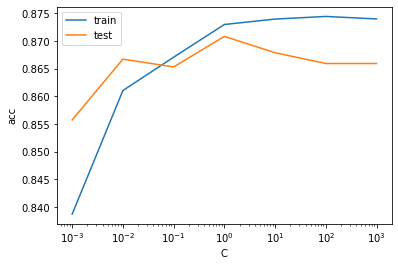

In [362]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(C_toUse, acc_train)
plt.plot(C_toUse, acc_val)
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('acc')
plt.legend(['train', 'test']);

print(f'best val score: {max(acc_val)}')
print(f'best C value: {C_toUse[np.argmax(acc_val)]}')

run a sinlg logistic regression with desired parameters and check confusion matrix

In [363]:
logreg = sklearn.linear_model.LogisticRegression(
        solver='lbfgs',
#         solver='sag',
#         solver='saga',
#         solver='newton-cg',
#         solver='liblinear',
    max_iter=8000, 
    C=10**(0),
    fit_intercept=True, 
    class_weight='balanced',
#     n_jobs=-1
).fit(features_train, labels_train)

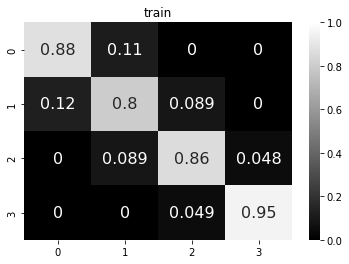

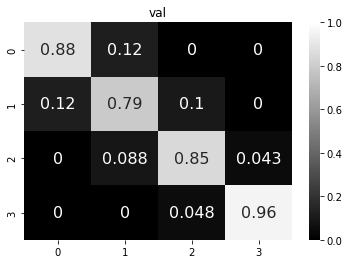

In [366]:
%matplotlib inline
import seaborn as sns

proba = logreg.predict_proba(features_train)
preds = np.argmax(proba, axis=1)

# preds = svm.predict(features_train_norm).astype(np.int32)

cm = classification.confusion_matrix(preds, labels_train.astype(np.int32))

plt.figure()
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'))
plt.title('train');



proba = logreg.predict_proba(features_val)
preds = np.argmax(proba, axis=1)

# preds = svm.predict(features_val_norm).astype(np.int32)

cm = classification.confusion_matrix(preds, labels_val.astype(np.int32))

plt.figure()
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'))
plt.title('val');


In [365]:
labels_sesh1 = np.load(r'/media/rich/bigSSD/for_Josh/SimCLR-Label-Data/mouse2_6__20210409/labels_round2_sesh1.npy')
labels_sesh2 = np.load(r'/media/rich/bigSSD/for_Josh/SimCLR-Label-Data/mouse2_6__20210409/labels_round2_sesh2.npy')

Text(0.5, 1.0, 'relabeling')

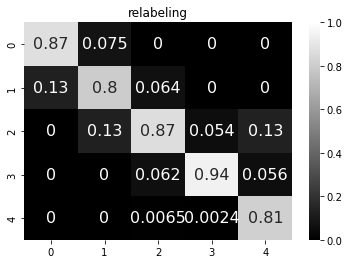

In [167]:
labels_sesh12cat = np.concatenate((labels_sesh1, labels_sesh2), axis=0)
labels_sesh21cat = np.concatenate((labels_sesh2, labels_sesh1), axis=0)
plt.figure()
sns.heatmap(
    classification.confusion_matrix(labels_sesh12cat.astype(np.int32), labels_sesh21cat.astype(np.int32)),
    annot=True, 
    annot_kws={"size": 16}, 
    vmax=1., 
    cmap=plt.get_cmap('gray')
)
plt.title('relabeling')

In [ ]:
[(name, params.shape) for name, params in model.state_dict().items()]

In [ ]:
%matplotlib notebook

layer_1 = model.state_dict()['base_model.0.0.0.weight'].cpu()
# layer_2 = model.state_dict()['base_model.0.6.3.block.1.0.weight'].cpu()
# layer_3 = model.state_dict()['base_model.0.7.0.block.1.0.weight'].cpu()
# layer_4 = model.state_dict()['base_model.0.7.0.block.1.0.weight'].cpu()


plotting_helpers.plot_image_grid(torch.cat([arr for arr in layer_1], dim=0), grid_shape=(15,15), kwargs_imshow={'vmax': 0.2});
# plotting_helpers.plot_image_grid(torch.cat([arr for arr in layer_2], dim=0), grid_shape=(6,6), kwargs_imshow={'vmax': 0.2});
# plotting_helpers.plot_image_grid(torch.cat([arr for arr in layer_3], dim=0), grid_shape=(4,6), kwargs_imshow={'vmax': 0.2});


In [84]:
from umap import UMAP

In [85]:
umap = UMAP(
    n_neighbors=30,
    n_components=2,
    metric='euclidean',
    metric_kwds=None,
    output_metric='euclidean',
    output_metric_kwds=None,
    n_epochs=None,
    learning_rate=1.0,
    init='spectral',
    min_dist=0.1,
    spread=1.0,
    low_memory=True,
    n_jobs=-1,
    set_op_mix_ratio=1.0,
    local_connectivity=1.0,
    repulsion_strength=1.0,
    negative_sample_rate=5,
    transform_queue_size=4.0,
    a=None,
    b=None,
    random_state=None,
    angular_rp_forest=False,
    target_n_neighbors=-1,
    target_metric='categorical',
    target_metric_kwds=None,
    target_weight=0.5,
    transform_seed=42,
    transform_mode='embedding',
    force_approximation_algorithm=False,
    verbose=False,
    tqdm_kwds=None,
    unique=False,
    densmap=False,
    dens_lambda=2.0,
    dens_frac=0.3,
    dens_var_shift=0.1,
    output_dens=False,
    disconnection_distance=None,
    precomputed_knn=(None, None, None),
)

In [86]:
embeddings = umap.fit_transform(features_nn)
# embeddings = umap.fit_transform(scores_nn)
# embeddings = umap.fit_transform(latents_swt)
# embeddings = umap.fit_transform(features_norm)

<IPython.core.display.Javascript object>


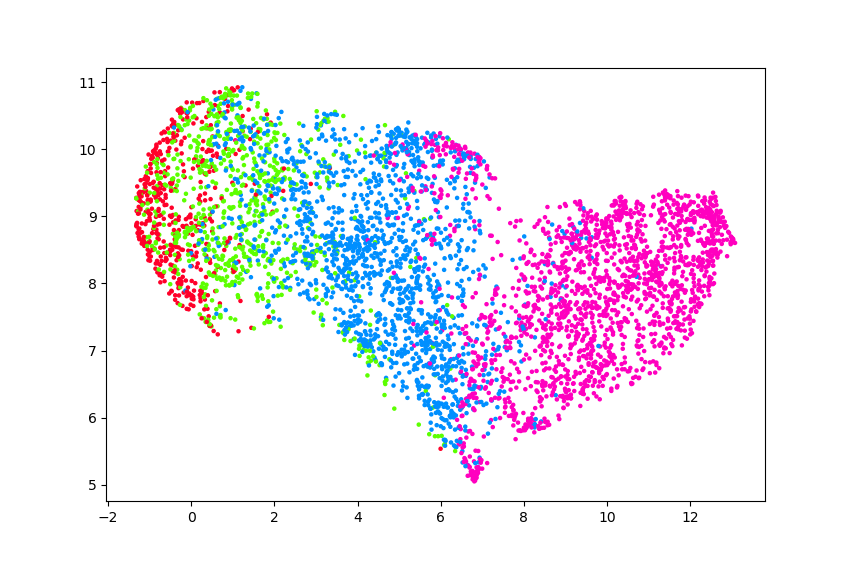

In [89]:
%matplotlib notebook

plt.figure()
plt.scatter(embeddings[:,0], embeddings[:,1], s=5, c=labels_clean, cmap='gist_rainbow')

<IPython.core.display.Javascript object>


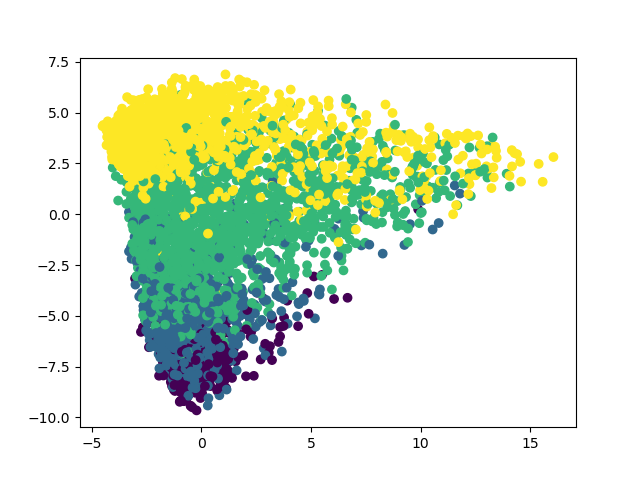

In [88]:
%matplotlib notebook

plt.figure()
plt.scatter(scores_nn[:,1], scores_nn[:,0], c=labels_clean)